Prompting Tasks: ['syntactic_bug_detection', 'spell_check', 'github_typo_check', 'json_repair', 'pos_detection', 'topic_classification', 'adding_odd_numbers', 'model_name_extraction']


Processing datasets: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'figures/dataset_test_scores_gemma.png'

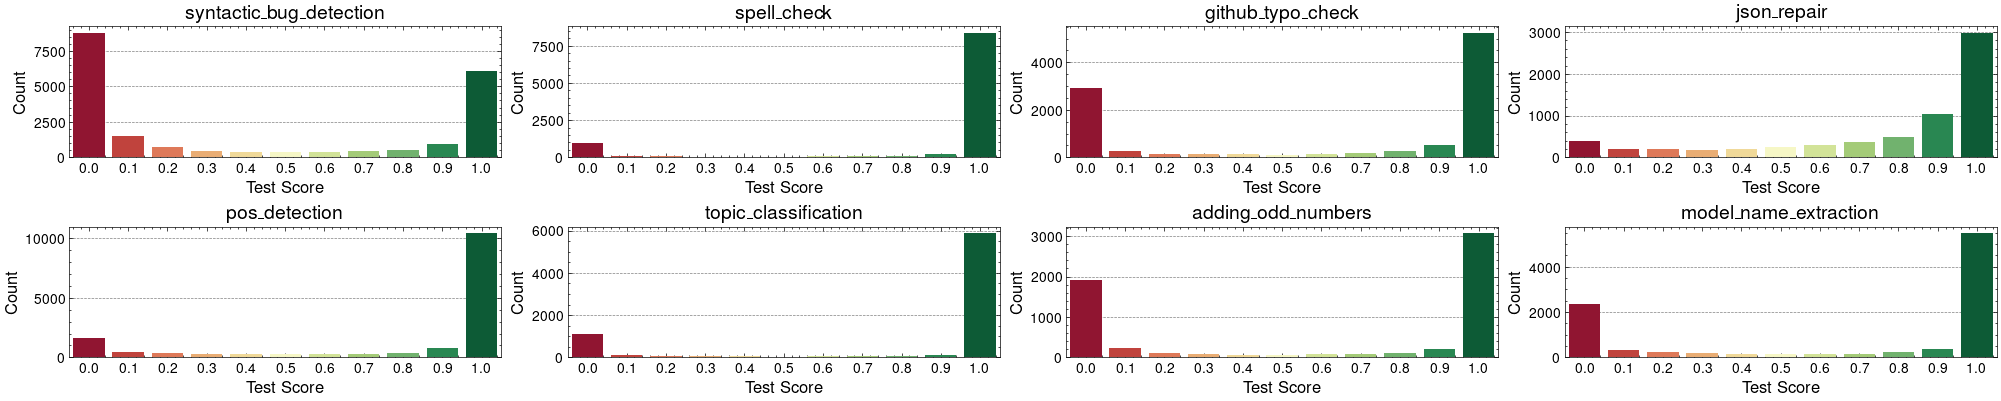

In [1]:
import json
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm

from analysis_utils import get_test_results_all_tasks, target_testsuites, get_test_results

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import torch
import random

import time
import gc

from analysis_utils import load_input_hidden_states

import scienceplots

plt.style.use(["science", "grid", "nature"])

plt.rcParams.update({
    "font.size": 12,           
    "axes.titlesize": 14,      
    "axes.labelsize": 12,      
    "xtick.labelsize": 10,     
    "ytick.labelsize": 10,     
    "legend.fontsize": 10,     
})

tasks = list(target_testsuites.keys())
print('Prompting Tasks:', tasks)

models = ['gemma', 'llama', 'mistral']

stat_rows = []
for model in models:
    inference_results, labels, test_scores = get_test_results_all_tasks(model)

    ncols = 4
    nrows = (len(tasks) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 2 * nrows), constrained_layout=True)
    axes = axes.flatten()


    for idx, task_name in enumerate(tasks):
        if task_name not in test_scores:
            print(f"Task {task_name} not found in test_scores.")
            fig.delaxes(axes[idx])
            continue
        
        scores = test_scores[task_name]
        value_counts = pd.Series(scores).value_counts().sort_index()
        
        stat_rows.append({
            'model': model,
            'task_name': task_name,
            'num_test_cases': len(scores),
            'avg_test_score': sum(scores) / len(scores),
            'all_correct_ratio': sum([1 for score in scores if score == 1.0]) / len(scores),
            'any_correct_ratio': sum([1 for score in scores if score > 0.0]) / len(scores),
            'major_correct_ratio': sum([1 for score in scores if score > 0.5]) / len(scores),
        })
        
        sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, ax=axes[idx], palette='RdYlGn', legend=False)
        axes[idx].set_title(f'{task_name}')
        axes[idx].set_xlabel('Test Score')
        axes[idx].set_ylabel('Count')

    for i in range(len(tasks), len(axes)):
        fig.delaxes(axes[i])
        
    # print(pd.DataFrame(stat_rows).to_markdown(index=False))

    fig.savefig(f'figures/dataset_test_scores_{model}.png')
    fig.savefig(f'figures/dataset_test_scores_{model}.pdf')
    
dataset_stat = pd.DataFrame(stat_rows)
dataset_stat

In [ ]:
pivot_df = dataset_stat.pivot(index='model', columns='task_name', values=['major_correct_ratio'])
display(pivot_df)

print(pivot_df.to_latex(float_format="%.2f"))

major_correct_ratio                                \
task_name  adding_odd_numbers github_typo_check json_repair   
model                                                         
gemma                0.591167            0.6302    0.789273   
llama                0.571833            0.4803    0.665549   
mistral              0.081833            0.2874    0.311291   

                                                           \
task_name model_name_extraction pos_detection spell_check   
model                                                       
gemma                  0.659327      0.789765      0.8770   
llama                  0.516004      0.735920      0.8023   
mistral                0.490724      0.675825      0.7675   

                                                        
task_name syntactic_bug_detection topic_classification  
model                                                   
gemma                    0.404230             0.814079  
llama                    0.335803             0.772500  
mistral                  0.280632             0.747237

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{major_correct_ratio} \\
task_name & adding_odd_numbers & github_typo_check & json_repair & model_name_extraction & pos_detection & spell_check & syntactic_bug_detection & topic_classification \\
model &  &  &  &  &  &  &  &  \\
\midrule
gemma & 0.59 & 0.63 & 0.79 & 0.66 & 0.79 & 0.88 & 0.40 & 0.81 \\
llama & 0.57 & 0.48 & 0.67 & 0.52 & 0.74 & 0.80 & 0.34 & 0.77 \\
mistral & 0.08 & 0.29 & 0.31 & 0.49 & 0.68 & 0.77 & 0.28 & 0.75 \\
\bottomrule
\end{tabular}

